##### Copyright 2018 The TensorFlow Authors.

In [19]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Text classification with an RNN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/text/tutorials/text_classification_rnn"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/text/blob/master/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/text/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This text classification tutorial trains a [recurrent neural network](https://developers.google.com/machine-learning/glossary/#recurrent_neural_network) on the [IMDB large movie review dataset](http://ai.stanford.edu/~amaas/data/sentiment/) for sentiment analysis.

## Setup

In [20]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()
np.set_printoptions(precision=3, suppress=True)

Import `matplotlib` and create a helper function to plot graphs:

In [21]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Setup input pipeline


The IMDB large movie review dataset is a *binary classification* dataset—all the reviews have either a *positive* or *negative* sentiment.

Download the dataset using [TFDS](https://www.tensorflow.org/datasets). See the [loading text tutorial](https://www.tensorflow.org/tutorials/load_data/text) for details on how to load this sort of data manually.


[155127, 62177]


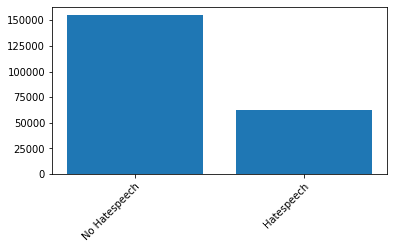

<Figure size 1152x432 with 0 Axes>

In [22]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


#
# Load the csv data.
#
def load_data_arrays():
    df_1 = pd.read_csv("datasets/1_preprocessed.csv")
    df_3 = pd.read_csv("datasets/3_preprocessed.csv")
    df_5 = pd.read_csv("datasets/5_preprocessed.csv")
    df_6 = pd.read_csv("datasets/6_preprocessed.csv")
    
    df = df_1.append(df_3)
    df = df.append(df_5)
    df = df.append(df_6)
    
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=True, stratify=df["is_hatespeech"])
    
    return train_df, test_df

def plot_data_distribution(labels_1, label_2):
    total = labels_1.reshape(-1).tolist()
    total.extend(label_2.reshape(-1).tolist())
    bins = sorted(list(set(total)))

    plt.bar(bins, [total.count(bin_val) for bin_val in bins])
    print([total.count(bin_val) for bin_val in bins])
    plt.xticks(bins,
               ["No Hatespeech", "Hatespeech"],
               rotation=45,
               rotation_mode="anchor",
               ha="right")

    plt.subplots_adjust(bottom=0.3)
    plt.figure(figsize=(16, 6))
    plt.show()

train_df, test_df = load_data_arrays()


plot_data_distribution(train_df['is_hatespeech'].values, test_df['is_hatespeech'].values)

In [23]:
# Convert the test- and train-DataFrames to Tensorflow Datasets

train_labels = np.eye(2)[train_df['is_hatespeech'].values]
train_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(np.asarray(train_df['text'].values, dtype=str), tf.string),
            tf.cast(train_labels, tf.int32)
        )
    )
)

test_labels = np.eye(2)[test_df['is_hatespeech'].values]
test_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(np.asarray(test_df['text'].values, dtype=str), tf.string),
            tf.cast(test_labels, tf.int32)
        )
    )
)

Next shuffle the data for training and create batches of these `(text, label)` pairs:

In [24]:
BUFFER_SIZE = 1000
BATCH_SIZE = 64

In [25]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [26]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy())
  print()
  print('labels: ', label.numpy())

texts:  [b'gunix altough not registered'
 b'redirect talkpoint of no return tv series'
 b'ok david if you want to replace the current text with yours doing the citations appropriately go ahead please change force him to led him though'
 b'u74\nive corrected the canadian navy flag and wikilink on the article has examples of useage for various navies'
 b'holi greetings hi i am wishing you a happy holi the unique indian celebration of color and brotherhood among all members of the humanity the festival falls on 15th march 2006 i have collected a gift pack of quotationsfor you contained in the sections do things differently and something more which are part of the ongoing discussion pertaining to my nomination of for adminship you are aware of the tradition that if you throw colored water on flames of burning holika you enable a prahlad to emerge from the flames i again convey holi greetings to you and your family'
 b'bitch watch tf out u on moose meat now'
 b'and stop trying to be logical

## Create the text encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:

In [27]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency: 

In [28]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'to', 'you', 'a', 'and', 'of', 'i', 'is',
       'that', 'in', 'it', 'for', 'this', 'not', 'on', 'be', 'are', 'as'],
      dtype='<U14')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):

In [29]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[  1,   1,  15, ...,   0,   0,   0],
       [490,   1,   7, ...,   0,   0,   0],
       [433,   1,  23, ...,   0,   0,   0]], dtype=int64)

With the default settings, the process is not completely reversible. There are three main reasons for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [30]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'gunix altough not registered'
Round-trip:  [UNK] [UNK] not [UNK]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

Original:  b'redirect talkpoint of no return tv series'
Round-trip:  redirect [UNK] of no [UNK] [UNK] series                                                                                                           

## Create the model

Above is a diagram of the model. 

1. This model can be build as a `tf.keras.Sequential`.

2. The first layer is the `encoder`, which converts the text to a sequence of token indices.

3. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

  This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

4. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output. 

  * The main advantage of a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

5. After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output. 


The code to implement this is below:

In [31]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, None, 64)          64000     
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 2)                 130       
                                                                 
Total params: 138,434
Trainable params: 138,434
Non-tr

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

The embedding layer [uses masking](https://www.tensorflow.org/guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [32]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


To confirm that this works as expected, evaluate a sentence twice. First, alone so there's no padding to mask:

In [33]:
# predict on a sample text without padding.

sample_text = ('How are you doing')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

[0.498 0.502]


Now, evaluate it again in a batch with a longer sentence. The result should be identical:

In [34]:
# predict on a sample text with padding

padding = "How are you doing " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

[0.498 0.502]


Compile the Keras model to configure the training process:

In [35]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(0.0001),
              metrics=['accuracy'])

## Train the model

In [36]:
history = model.fit(train_dataset, epochs=5,
                    validation_data=test_dataset,
                    validation_steps=10)

Epoch 1/5
2717/2717 [==============================] - 113s 39ms/step - loss: 0.2686 - accuracy: 0.8888 - val_loss: 0.2487 - val_accuracy: 0.9016
Epoch 2/5
2717/2717 [==============================] - 105s 39ms/step - loss: 0.2004 - accuracy: 0.9214 - val_loss: 0.2458 - val_accuracy: 0.9016
Epoch 3/5
2717/2717 [==============================] - 105s 39ms/step - loss: 0.1959 - accuracy: 0.9225 - val_loss: 0.2404 - val_accuracy: 0.9062
Epoch 4/5
2717/2717 [==============================] - 105s 39ms/step - loss: 0.1930 - accuracy: 0.9232 - val_loss: 0.2349 - val_accuracy: 0.9062
Epoch 5/5
2717/2717 [==============================] - 105s 39ms/step - loss: 0.1908 - accuracy: 0.9235 - val_loss: 0.2340 - val_accuracy: 0.9141


In [37]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

680/680 [==============================] - 11s 16ms/step - loss: 0.1960 - accuracy: 0.9212
Test Loss: 0.19596855342388153
Test Accuracy: 0.9212167263031006


In [38]:
# Save the model
!mkdir models
model.save('models/rnn_one_with_stopwords', save_format='tf')

Ein Unterverzeichnis oder eine Datei mit dem Namen "models" existiert bereits.


INFO:tensorflow:Assets written to: models/rnn_one_with_stopwords\assets


INFO:tensorflow:Assets written to: models/rnn_one_with_stopwords\assets


(0.0, 0.2725337639451027)

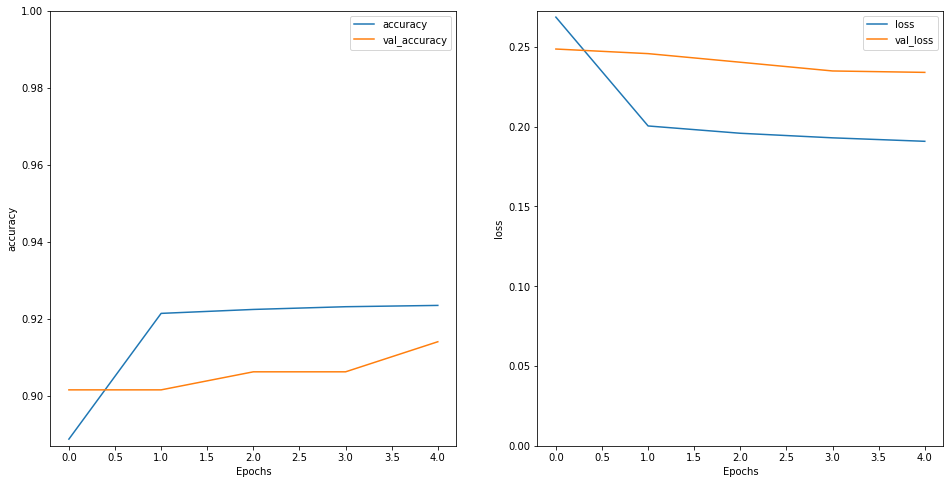

In [39]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Run a prediction on a new sentence:

If the prediction is >= 0.0, it is positive else it is negative.

In [40]:
sample_text = ['That was very nice of you to say', 'You stupid fucking bitch']
predictions = model.predict(np.array(sample_text))
print(predictions)

[[0.957 0.043]
 [0.    1.   ]]


## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.

* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

Here is what the flow of information looks like with `return_sequences=True`:

![layered_bidirectional](images/layered_bidirectional.png)

The interesting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:

In [41]:
model_two = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation='softmax')
])

print(model_two.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding_2 (Embedding)     (None, None, 64)          64000     
                                                                 
 bidirectional_2 (Bidirectio  (None, None, 128)        66048     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                      

In [42]:
model_two.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(0.0001),
              metrics=['accuracy'])

In [43]:
history_two = model_two.fit(train_dataset, epochs=5,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/5
2717/2717 [==============================] - 202s 71ms/step - loss: 0.2717 - accuracy: 0.8912 - val_loss: 0.2202 - val_accuracy: 0.9167
Epoch 2/5
2717/2717 [==============================] - 265s 97ms/step - loss: 0.2058 - accuracy: 0.9210 - val_loss: 0.2156 - val_accuracy: 0.9161
Epoch 3/5
2717/2717 [==============================] - 478s 176ms/step - loss: 0.2009 - accuracy: 0.9224 - val_loss: 0.2120 - val_accuracy: 0.9177
Epoch 4/5
2717/2717 [==============================] - 941s 346ms/step - loss: 0.1985 - accuracy: 0.9224 - val_loss: 0.2128 - val_accuracy: 0.9146
Epoch 5/5
2717/2717 [==============================] - 192s 71ms/step - loss: 0.1966 - accuracy: 0.9228 - val_loss: 0.2114 - val_accuracy: 0.9146


In [44]:
test_loss, test_acc = model_two.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

680/680 [==============================] - 20s 30ms/step - loss: 0.1979 - accuracy: 0.9209
Test Loss: 0.19787664711475372
Test Accuracy: 0.9208716154098511


In [45]:
# predict on a sample text without padding.

sample_text = ['You are such a stupid fucking whore',
               'I would not recommend this movie.']
predictions = model_two.predict(np.array(sample_text))

print(predictions)

[[0.001 0.999]
 [0.879 0.121]]


In [46]:
# Save the model
!mkdir models
model_two.save('models/rnn_two_with_stopwords', save_format='tf')

Ein Unterverzeichnis oder eine Datei mit dem Namen "models" existiert bereits.


INFO:tensorflow:Assets written to: models/rnn_two_with_stopwords\assets


INFO:tensorflow:Assets written to: models/rnn_two_with_stopwords\assets


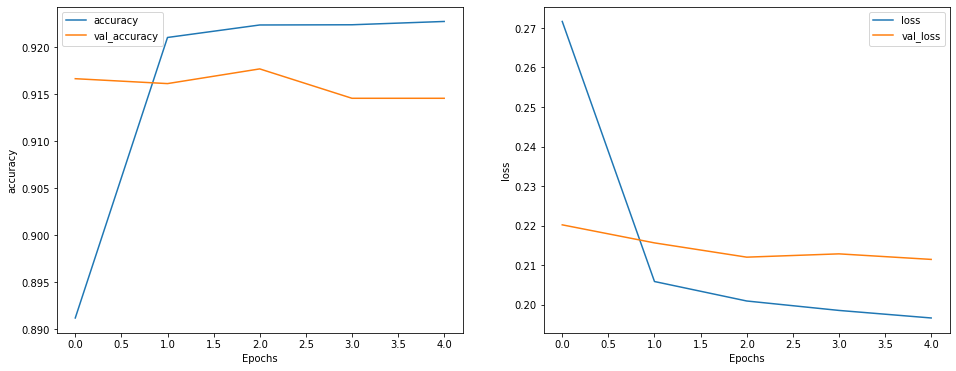

In [47]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history_two, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history_two, 'loss')

Check out other existing recurrent layers such as [GRU layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU).

If you're interestied in building custom RNNs, see the [Keras RNN Guide](https://www.tensorflow.org/guide/keras/rnn).
